## Import code

In [1]:
%load_ext autoreload
%autoreload 2 
# Autoreloads packages when changes are detected

from src.Data import * # Class containing the data
from src.Assignment import * # Class containing an assignment
from src.Model import * # Class containing a Pulp model used for optimization
from src.ModelColumnGen import * # Class containing Pulp model that optimizes using column generation
from src.ModelFracStable import * # Class containing a Pulp model for finding an fractionally stable stochastic improvement
from src.ModelHeuristicLP import * # Class containing heuristic that will use generated weakly stable matchings as an input
from src.DataGen import * # Generate student preferences and school priorities
from src.DataGenEE import * # Generate data according to the method by Erdil & Ergin (2008)
from src.EADAM import * # EADAM implementation
from src.DA_STB import * # Generate DA assignment with single tie-breaking (STB)
from src.ErdilErgin import * # Erdil & Ergil their implementation of Stable Improvement Cycles algorithm + alternative implementation DA
from src.SICs import * # Adaptation of SICs algorithm to our code
from src.Simulations import * # Run solution methods for multiple data instances
from src.SimulationsEvaluate import * # Functions that evaluate simulation results

from ReadData.Estonia.Estonia import * # Read Estonian data

import pickle # to export data

# If you get error that pulp and gurobipy are not installed: uncomment following lines in src/Data file:(keep exclamation marks)
    #! pip install pulp
    #! pip install gurobipy

## Column generation formulation

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
#[n_students,n_schools,seed] = [40,10,10]
#[n_students,n_schools,seed] = [50,12,10] # Nice, good illustration of results!
#[n_students,n_schools,seed] = [35,15,0] # Clean simple example where EE has no improvement and we have
[n_students,n_schools,seed] = [200,15,10] # Larger. No improvement upon heuristic. But still, heuristic improves quite a lot on EE (93 instead of 90, avg 0.43 instead of 0.38 improvement)
name = str(n_students) + "_" + str(n_schools) + "_" + str(seed)
MyData = generate_data(n_students = n_students, n_schools=n_schools, parameters = parameters, name=name, print_data=False, seed = seed)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 400
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

In [ ]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)
    
S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= 20, n_sol_pricing = 10, gap_pricing= 0.1, bool_ColumnGen= True, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
print(S.A.assignment)
print(S.Xdecomp)
print(S.Xdecomp_coeff)

In [ ]:
# Asses and visualize the difference
name_diff = name + '_diff'
diff = Assignment(MyData, S.A.assignment - S.A_DA_prob, name_diff)
diffEE = Assignment(MyData, S.A.assignment - S.A_SIC.assignment)
diff.visualize()
diffEE.visualize()

In [ ]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


In [ ]:
# Export data using pickle
A = [0, S]
print(A[1])

# Save to file
with open('pickle_test.pkl', 'wb') as f:
    pickle.dump(A, f)

# Later, load it back
with open('pickle_test.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

print(A[1].A.assignment)


# Column generation Erdil & Ergin data

In [2]:
n_stud = 40
n_schools = 4
pref_list_length = n_schools
alpha_in = 0.75
beta_in = 0.5
seed = 813847339
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)

The data instance has the following properties: 

	40 students.
	4 schools. 

 	PREFERENCES:
	0	0 1 3 2 
	1	1 0 2 3 
	2	0 2 1 3 
	3	1 0 2 3 
	4	0 1 3 2 
	5	1 0 2 3 
	6	1 0 3 2 
	7	1 0 3 2 
	8	1 0 3 2 
	9	1 0 2 3 
	10	1 2 3 0 
	11	1 2 0 3 
	12	1 0 3 2 
	13	1 0 3 2 
	14	1 0 3 2 
	15	1 2 0 3 
	16	0 1 2 3 
	17	1 0 2 3 
	18	1 0 2 3 
	19	1 0 3 2 
	20	0 1 3 2 
	21	1 0 2 3 
	22	1 3 0 2 
	23	1 0 2 3 
	24	1 0 2 3 
	25	1 0 3 2 
	26	0 1 2 3 
	27	1 0 3 2 
	28	1 0 2 3 
	29	1 0 3 2 
	30	1 0 2 3 
	31	1 3 2 0 
	32	1 3 0 2 
	33	1 3 0 2 
	34	1 0 2 3 
	35	1 0 2 3 
	36	1 0 3 2 
	37	1 0 2 3 
	38	1 0 2 3 
	39	0 1 2 3 


 	CAPACITIES & PRIORITIES:
	0	10	{0 3 4 6 7 13 14 16 20 23 24 26 29 33 34 35} {1 2 5 8 9 10 11 12 15 17 18 19 21 22 25 27 28 30 31 32 36 37 38 39} 
	1	10	{1 5 8 9 12 17 18 19 21 28 37 38} {0 2 3 4 6 7 10 11 13 14 15 16 20 22 23 24 25 26 27 29 30 31 32 33 34 35 36 39} 
	2	10	{2 10 11 15 30} {0 1 3 4 5 6 7 8 9 12 13 14 16 17 18 19 20 21 22 23 24 25 26 27 28 29 31 32 33 34 35 36 37 38 39} 
	3	10

Students in ties: 40
Tie-breaking rules needed: 815915283247897734345611269596115894272000000000
Tie-breaking rules sampled: 1000


Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 957.65perturb/s]


STATISTICS BEFORE:

Average rank: 1.9889499999999998.



Compute SICs for matchings: 100%|██████████| 998/998 [00:00<00:00, 4351.83matching/s]


STATISTICS AFTER:

Average rank: 1.988950000000002.

Students in ties: 40
Tie-breaking rules needed: 815915283247897734345611269596115894272000000000
Tie-breaking rules sampled: 1000


Generate EADAM_STB: 100%|██████████| 1000/1000 [00:00<00:00, 1011.65perturb/s]



Average rank: 1.9889499999999998.



[[0, 4],
 [0, 20],
 [1, 5],
 [1, 9],
 [1, 17],
 [1, 18],
 [1, 21],
 [1, 28],
 [1, 37],
 [1, 38],
 [3, 23],
 [3, 24],
 [3, 34],
 [3, 35],
 [4, 20],
 [5, 9],
 [5, 17],
 [5, 18],
 [5, 21],
 [5, 28],
 [5, 37],
 [5, 38],
 [6, 7],
 [6, 13],
 [6, 14],
 [6, 29],
 [7, 13],
 [7, 14],
 [7, 29],
 [8, 12],
 [8, 19],
 [9, 17],
 [9, 18],
 [9, 21],
 [9, 28],
 [9, 37],
 [9, 38],
 [10, 11],
 [10, 15],
 [11, 15],
 [12, 19],
 [13, 14],
 [13, 29],
 [14, 29],
 [16, 26],
 [17, 18],
 [17, 21],
 [17, 28],
 [17, 37],
 [17, 38],
 [18, 21],
 [18, 28],
 [18, 37],
 [18, 38],
 [21, 28],
 [21, 37],
 [21, 38],
 [22, 31],
 [22, 32],
 [23, 24],
 [23, 34],
 [23, 35],
 [24, 34],
 [24, 35],
 [25, 27],
 [25, 36],
 [27, 36],
 [28, 37],
 [28, 38],
 [31, 32],
 [34, 35],
 [37, 38]]

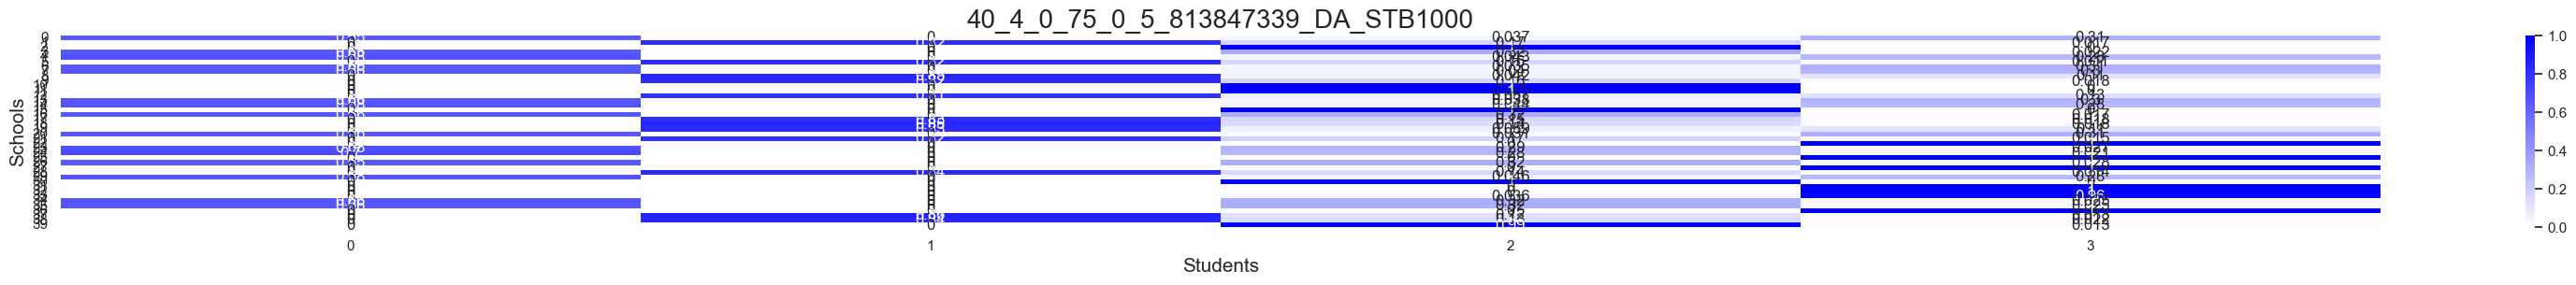

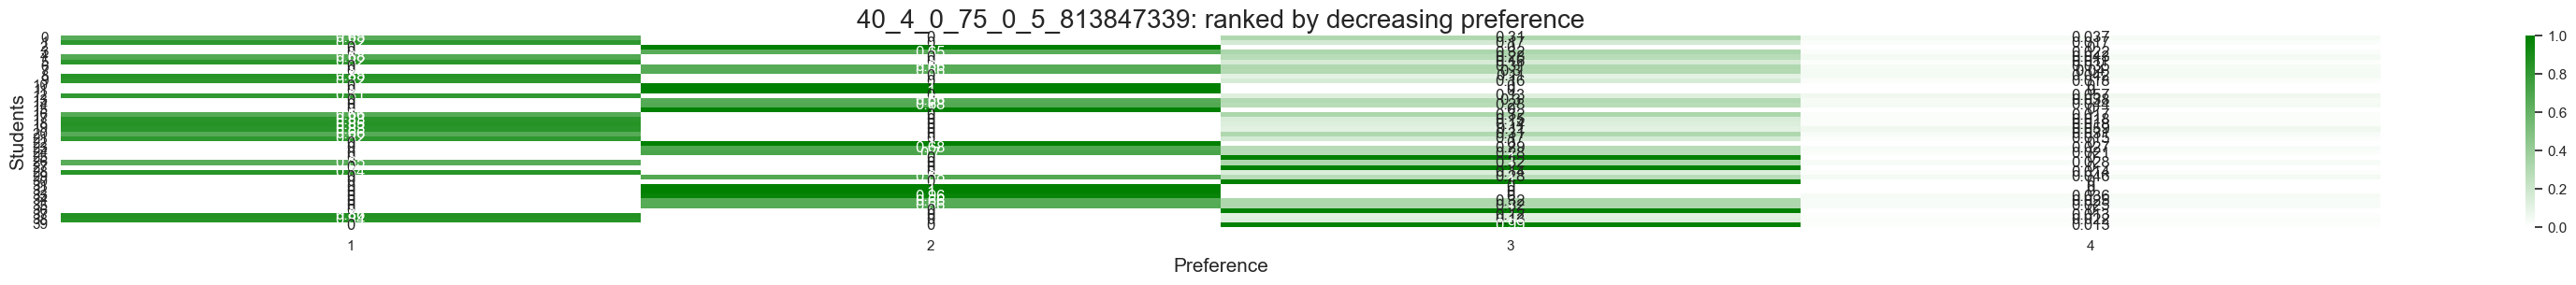

<Figure size 4000x266.667 with 0 Axes>

In [3]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'EE', bool_SIC, 813847339, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

A_EADAM = EADAM_STB(MyData, n_iter, 813847339, True)
A_EADAM.statistics(True)

A.visualize()
A.find_identical_students(True)

In [5]:
# Solve the formulations
bool_identical_students= True
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, bool_identical_students, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)
S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= 600, n_sol_pricing = 100, gap_solutionpool_pricing= 0.2, MIPGap = 0.1, bool_ColumnGen= True, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 100%|██████████| 998/998 [00:01<00:00, 629.49var/s]



Average rank DA : 1.9889499999999998.


Average rank warm start solution : 1.988950000000002.




Pricing exclude found matchings: 100%|██████████| 998/998 [00:01<00:00, 985.24matchings/s] 


Number of matchings: 998
ITERATION: 1

 ****** MASTER ****** 

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 495 rows, 998 columns and 185875 nonzeros
Model fingerprint: 0x874f46a6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+00]
Presolve removed 355 rows and 0 columns
Presolve time: 0.03s
Presolved: 140 rows, 1081 columns, 81491 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.730e+03
 Factor NZ  : 9.870e+03 (roughly 1 MB of memory)
 Factor Ops : 9.245e+05 (less than 1 second per iteration)
 Threads    : 3

Barrier performed 0 iterations in 0.05 seco

KeyboardInterrupt: 

Exception ignored in: 'gurobipy._core.logcallbackstub'
Traceback (most recent call last):
  File "c:\Users\tdemeule\AppData\Local\anaconda3\Lib\site-packages\ipykernel\iostream.py", line 624, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]

KeyboardInterrupt: 



Cutting planes:
  Gomory: 4
  Lift-and-project: 37
  Cover: 18
  MIR: 55
  StrongCG: 2
  Flow cover: 35
  GUB cover: 1
  Inf proof: 2
  Zero half: 5
  RLT: 8

Explored 23572 nodes (137331 simplex iterations) in 56.52 seconds (53.88 work units)
Thread count was 8 (of 8 available processors)

Solution count 100: -0.375 -0.375 -0.375 ... -0.4

Time limit reached
Best objective -3.750000000000e-01, best bound -2.250000000000e-01, gap 40.0000%
Gurobi status= 9
Pricing status 0

Time limit of  600 seconds exceeded!

Rank best found solution:	 1.9718499999999994
Rank first iteration: 	 1.9718499999999997
Rank warm start solution: 	 1.988950000000002
Original average rank: 	 1.9889499999999998


In [102]:
#print(len(S.Xdecomp))
#print(len(MyModel.w))
#print(A_EADAM.statistics())
print(S.A.statistics())
#A_EADAM.visualize()
#S.A.visualize()
S.A.compare(A.assignment, True)
#print(S.avg_ranks)

1.2103750000000004
Number of improving studentss 34
Average rank improvement 0.17614705882352957
Median rank improvement 0.12450000000000017


{'students_improving': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  True,
  True,
  False,
  True,
  False,
  False,
  True,
  True,
  True,
  True,
  True],
 'n_students_improving': 34,
 'rank_increase_by_stud': [0.14200000000000013,
  0.1120000000000001,
  0.13700000000000023,
  0.3870000000000007,
  0.07200000000000051,
  0.07000000000000006,
  0.07600000000000007,
  0.08400000000000007,
  0.2809999999999997,
  0.2650000000000001,
  0.050000000000000044,
  0.06000000000000005,
  0.05699999999999994,
  0,
  0.018000000000000016,
  0.007000000000000339,
  0.31299999999999994,
  0.34399999999999986,
  0.32000000000000006,
  0.06800000000000028,
  0.020999999999999908,
  0.859,
  0.19799999999999995,
  0.19700000000000029,
  0.367,
  0.05200000000000049,
  0.38900000000000046,
  0,
  0,
  0.13900000

In [60]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print(resultEE)
print(result)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


{'students_improving': [True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True], 'n_students_improving': 2, 'rank_increase_by_stud': [0.03599999999999892, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.024999999999999023], 'average_rank_increase': 0.030499999999998972, 'median_rank_improvement': 0.030499999999998972}
{'students_improving': [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], 'n_students_improving': 0, 'rank_increase_by_stud': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'average_rank_increase': 0, 'median_rank_improvement': 0}
Number of improving students EE & us 2 0
Average improvement rank EE & us 0.030499999999998972 0
Median rank improvement 0.030499999999998972 0


In [ ]:
# # Asses and visualize the difference
# name_diff = MyData.file_name + '_diff'
# diff = Assignment(MyData, S.A.assignment - S.A_DA_prob, name_diff)
# diffEE = Assignment(MyData, S.A.assignment - S.A_SIC.assignment)
# diff.visualize() # Difference compared to DA
# diffEE.visualize() # Difference compared to EE

# Simulations

In [ ]:
#n_students_schools = [[100,2],[200,4],[400,8], [800, 16], [1600, 32], [3200, 64]]
n_students_schools = [[200,4],[200,8],[200,12], [200, 16], [200, 20], [200, 24], [200, 28], [200, 32]]

compare_solutions = ["SD_UPON_DA", "SD_UPON_EE", "SD_UPON_EADA"]
    # All options are: ["SD_UPON_DA", "SD_UPON_EE", "SD_UPON_EADA"]

n_iterations_simul = 10
n_match = 1000
time_lim = 60
n_sol_pricing = 20
gap_solutionpool_pricing = 0.15 
MIPGap = 0.05
bool_ColumnGen = False
bool_identical_students = False

seed = 0

#ALPHA_INCREMENT = 0.20
#BETA_INCREMENT = 0.5

#alpha = list(np.arange(0, 1.0, ALPHA_INCREMENT)) + [1.0]
#beta = list(np.arange(0, 1.0, BETA_INCREMENT)) + [1.0]
alpha = [0.25]
beta = [0.5]


S_vector = SimulationCG(compare_solutions, n_students_schools, alpha, beta, n_iterations_simul, n_match, time_lim, seed, n_sol_pricing, gap_solutionpool_pricing, MIPGap, bool_ColumnGen, bool_identical_students, True)


Data instances:   0%|          | 0/8 [00:00<?, ?inst/s]


n,m,alpha, beta, seed 200 4 0.25 0.5 906691059
Students in ties: 200
Tie-breaking rules sampled: 1000

























































































Generate DA_STB: 100%|██████████| 1000/1000 [00:10<00:00, 99.63perturb/s]


STATISTICS BEFORE:

Average rank: 1.3820900000000007.
























Compute SICs for matchings: 100%|██████████| 1000/1000 [00:02<00:00, 416.81matching/s]


STATISTICS AFTER:

Average rank: 1.3284450000000019.

Students in ties: 200
Tie-breaking rules sampled: 1000



























































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:14<00:00, 69.48perturb/s]












































Master: add decision variables: 100%|██████████| 1000/1000 [00:05<00:00, 199.92var/s]



Average rank DA : 1.3820900000000007.


Average rank warm start solution : 1.3284450000000019.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3193274994032897
Average rank of heuristic: 	 1.3193274994032897
Rank first iteration: 	 1.3193274994032897
Rank warm start solution: 	 1.3284450000000019
Original average rank: 	 1.3820900000000007

























Master: add decision variables: 100%|██████████| 1000/1000 [00:02<00:00, 416.45var/s]



Average rank DA : 1.3284450000000019.


Average rank warm start solution : 1.3284450000000019.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3256199999999971
Average rank of heuristic: 	 1.3256199999999971
Rank first iteration: 	 1.3256199999999971
Rank warm start solution: 	 1.3284450000000019
Original average rank: 	 1.3284450000000019


























Master: add decision variables: 100%|██████████| 1000/1000 [00:02<00:00, 378.14var/s]



Average rank DA : 1.3270499999999998.


Average rank warm start solution : 1.3284450000000019.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3284449999999932
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 4 0.25 0.5 413653999
Students in ties: 200
Tie-breaking rules sampled: 1000








































































Generate DA_STB: 100%|██████████| 1000/1000 [00:08<00:00, 123.09perturb/s]


STATISTICS BEFORE:

Average rank: 1.2734700000000005.














Compute SICs for matchings: 100%|██████████| 1000/1000 [00:01<00:00, 971.70matching/s]


STATISTICS AFTER:

Average rank: 1.2390350000000003.

Students in ties: 200
Tie-breaking rules sampled: 1000













































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:08<00:00, 120.35perturb/s]




























Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 321.89var/s]



Average rank DA : 1.2734700000000005.


Average rank warm start solution : 1.2390350000000003.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2243299999999973
Average rank of heuristic: 	 1.2243299999999973
Rank first iteration: 	 1.2243299999999973
Rank warm start solution: 	 1.2390350000000003
Original average rank: 	 1.2734700000000005





























Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 301.04var/s]



Average rank DA : 1.2390350000000003.


Average rank warm start solution : 1.2390350000000003.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2329099999999968
Average rank of heuristic: 	 1.2329099999999968
Rank first iteration: 	 1.2329099999999968
Rank warm start solution: 	 1.2390350000000003
Original average rank: 	 1.2390350000000003





























Master: add decision variables: 100%|██████████| 1000/1000 [00:02<00:00, 337.68var/s]



Average rank DA : 1.237095000000001.


Average rank warm start solution : 1.2390350000000003.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2327439950829113
Average rank of heuristic: 	 1.2327439950829113
Rank first iteration: 	 1.2327439950829113
Rank warm start solution: 	 1.2390350000000003
Original average rank: 	 1.237095000000001



n,m,alpha, beta, seed 200 4 0.25 0.5 813847339
Students in ties: 200
Tie-breaking rules sampled: 1000













































































Generate DA_STB: 100%|██████████| 1000/1000 [00:10<00:00, 98.54perturb/s]


STATISTICS BEFORE:

Average rank: 1.147829999999999.













Compute SICs for matchings: 100%|██████████| 1000/1000 [00:00<00:00, 1028.88matching/s]


STATISTICS AFTER:

Average rank: 1.1321400000000006.

Students in ties: 200
Tie-breaking rules sampled: 1000









































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:07<00:00, 127.82perturb/s]
























Master: add decision variables: 100%|██████████| 1000/1000 [00:02<00:00, 386.50var/s]



Average rank DA : 1.147829999999999.


Average rank warm start solution : 1.1321400000000006.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.1275749999999989
Average rank of heuristic: 	 1.1275749999999989
Rank first iteration: 	 1.1275749999999989
Rank warm start solution: 	 1.1321400000000006
Original average rank: 	 1.147829999999999



























Master: add decision variables: 100%|██████████| 1000/1000 [00:02<00:00, 382.24var/s]



Average rank DA : 1.1321400000000006.


Average rank warm start solution : 1.1321400000000006.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.1299449999999989
Average rank of heuristic: 	 1.1299449999999989
Rank first iteration: 	 1.1299449999999989
Rank warm start solution: 	 1.1321400000000006
Original average rank: 	 1.1321400000000006




























Master: add decision variables: 100%|██████████| 1000/1000 [00:02<00:00, 365.78var/s]



Average rank DA : 1.1323149999999993.


Average rank warm start solution : 1.1321400000000006.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.1298399999999993
Average rank of heuristic: 	 1.1298399999999993
Rank first iteration: 	 1.1298399999999993
Rank warm start solution: 	 1.1321400000000006
Original average rank: 	 1.1323149999999993



n,m,alpha, beta, seed 200 4 0.25 0.5 955892128
Students in ties: 200
Tie-breaking rules sampled: 1000













































































Generate DA_STB: 100%|██████████| 1000/1000 [00:09<00:00, 105.78perturb/s]


STATISTICS BEFORE:

Average rank: 1.6011149999999994.














Compute SICs for matchings: 100%|██████████| 1000/1000 [00:01<00:00, 933.16matching/s]


STATISTICS AFTER:

Average rank: 1.5987950000000004.

Students in ties: 200
Tie-breaking rules sampled: 1000


















































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:09<00:00, 110.23perturb/s]

























Master: add decision variables: 100%|██████████| 1000/1000 [00:02<00:00, 374.73var/s]



Average rank DA : 1.6011149999999994.


Average rank warm start solution : 1.5987950000000004.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5974499999999956
Average rank of heuristic: 	 1.5974499999999956
Rank first iteration: 	 1.5974499999999956
Rank warm start solution: 	 1.5987950000000004
Original average rank: 	 1.6011149999999994






























Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 325.12var/s]



Average rank DA : 1.5987950000000004.


Average rank warm start solution : 1.5987950000000004.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5982499999999975
Average rank of heuristic: 	 1.5982499999999975
Rank first iteration: 	 1.5982499999999975
Rank warm start solution: 	 1.5987950000000004
Original average rank: 	 1.5987950000000004





























Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 331.26var/s]



Average rank DA : 1.5493300000000003.


Average rank warm start solution : 1.5987950000000004.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5987949999999953
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 4 0.25 0.5 451585301
Students in ties: 200
Tie-breaking rules sampled: 1000















































































Generate DA_STB: 100%|██████████| 1000/1000 [00:09<00:00, 108.57perturb/s]


STATISTICS BEFORE:

Average rank: 1.2965599999999995.




















Compute SICs for matchings: 100%|██████████| 1000/1000 [00:01<00:00, 531.75matching/s]


STATISTICS AFTER:

Average rank: 1.2238800000000003.

Students in ties: 200
Tie-breaking rules sampled: 1000
























































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:09<00:00, 101.30perturb/s]































Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 289.18var/s]



Average rank DA : 1.2965599999999995.


Average rank warm start solution : 1.2238800000000003.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2109992343382996
Average rank of heuristic: 	 1.2109992343382996
Rank first iteration: 	 1.2109992343382996
Rank warm start solution: 	 1.2238800000000003
Original average rank: 	 1.2965599999999995































Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 298.61var/s]



Average rank DA : 1.2238800000000003.


Average rank warm start solution : 1.2238800000000003.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.217844999999998
Average rank of heuristic: 	 1.217844999999998
Rank first iteration: 	 1.217844999999998
Rank warm start solution: 	 1.2238800000000003
Original average rank: 	 1.2238800000000003



























Master: add decision variables: 100%|██████████| 1000/1000 [00:02<00:00, 367.01var/s]



Average rank DA : 1.2217299999999993.


Average rank warm start solution : 1.2238800000000003.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2238799999999987
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 4 0.25 0.5 43469773
Students in ties: 200
Tie-breaking rules sampled: 1000



























































































Generate DA_STB: 100%|██████████| 1000/1000 [00:10<00:00, 99.44perturb/s]


STATISTICS BEFORE:

Average rank: 1.0205349999999986.












Compute SICs for matchings: 100%|██████████| 800/800 [00:00<00:00, 845.05matching/s]


STATISTICS AFTER:

Average rank: 1.015965.

Students in ties: 200
Tie-breaking rules sampled: 1000












































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:08<00:00, 118.56perturb/s]






















Master: add decision variables: 100%|██████████| 708/708 [00:02<00:00, 280.75var/s]



Average rank DA : 1.0205349999999986.


Average rank warm start solution : 1.015965.


Number of matchings: 708
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.0126450000000002
Average rank of heuristic: 	 1.0126450000000002
Rank first iteration: 	 1.0126450000000002
Rank warm start solution: 	 1.015965
Original average rank: 	 1.0205349999999986






























Master: add decision variables: 100%|██████████| 708/708 [00:03<00:00, 208.91var/s]



Average rank DA : 1.015965.


Average rank warm start solution : 1.015965.


Number of matchings: 708
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.0141850000000006
Average rank of heuristic: 	 1.0141850000000006
Rank first iteration: 	 1.0141850000000006
Rank warm start solution: 	 1.015965
Original average rank: 	 1.015965











































Master: add decision variables: 100%|██████████| 708/708 [00:04<00:00, 148.41var/s]



Average rank DA : 1.0158299999999998.


Average rank warm start solution : 1.015965.


Number of matchings: 708
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.0140900000000004
Average rank of heuristic: 	 1.0140900000000004
Rank first iteration: 	 1.0140900000000004
Rank warm start solution: 	 1.015965
Original average rank: 	 1.0158299999999998



n,m,alpha, beta, seed 200 4 0.25 0.5 278009742
Students in ties: 200
Tie-breaking rules sampled: 1000

































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:15<00:00, 64.74perturb/s]


STATISTICS BEFORE:

Average rank: 1.1464149999999997.
















Compute SICs for matchings: 100%|██████████| 1000/1000 [00:01<00:00, 782.25matching/s]


STATISTICS AFTER:

Average rank: 1.1206350000000005.

Students in ties: 200
Tie-breaking rules sampled: 1000




















































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:09<00:00, 107.36perturb/s]






























Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 303.63var/s]



Average rank DA : 1.1464149999999997.


Average rank warm start solution : 1.1206350000000005.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.1150499999999983
Average rank of heuristic: 	 1.1150499999999983
Rank first iteration: 	 1.1150499999999983
Rank warm start solution: 	 1.1206350000000005
Original average rank: 	 1.1464149999999997































Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 312.83var/s]



Average rank DA : 1.1206350000000005.


Average rank warm start solution : 1.1206350000000005.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.120165
Average rank of heuristic: 	 1.120165
Rank first iteration: 	 1.120165
Rank warm start solution: 	 1.1206350000000005
Original average rank: 	 1.1206350000000005






































Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 256.32var/s]



Average rank DA : 1.1217849999999998.


Average rank warm start solution : 1.1206350000000005.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.1208399999999985
Average rank of heuristic: 	 1.1208399999999985
Rank first iteration: 	 1.1208399999999985
Rank warm start solution: 	 1.1206350000000005
Original average rank: 	 1.1217849999999998



n,m,alpha, beta, seed 200 4 0.25 0.5 548977048
Students in ties: 200
Tie-breaking rules sampled: 1000
























































































Generate DA_STB: 100%|██████████| 1000/1000 [00:09<00:00, 101.05perturb/s]


STATISTICS BEFORE:

Average rank: 1.2424799999999998.
















Compute SICs for matchings: 100%|██████████| 1000/1000 [00:01<00:00, 733.96matching/s]


STATISTICS AFTER:

Average rank: 1.1921850000000007.

Students in ties: 200
Tie-breaking rules sampled: 1000



























































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:10<00:00, 98.40perturb/s]





























Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 313.46var/s]



Average rank DA : 1.2424799999999998.


Average rank warm start solution : 1.1921850000000007.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.1805795456242927
Average rank of heuristic: 	 1.1805795456242927
Rank first iteration: 	 1.1805795456242927
Rank warm start solution: 	 1.1921850000000007
Original average rank: 	 1.2424799999999998
































Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 303.89var/s]



Average rank DA : 1.1921850000000007.


Average rank warm start solution : 1.1921850000000007.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.1913649999999996
Average rank of heuristic: 	 1.1913649999999996
Rank first iteration: 	 1.1913649999999996
Rank warm start solution: 	 1.1921850000000007
Original average rank: 	 1.1921850000000007
































Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 302.49var/s]



Average rank DA : 1.1885400000000006.


Average rank warm start solution : 1.1921850000000007.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.192184999999997
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 4 0.25 0.5 521760889
Students in ties: 200
Tie-breaking rules sampled: 1000



















































































Generate DA_STB: 100%|██████████| 1000/1000 [00:10<00:00, 95.10perturb/s]


STATISTICS BEFORE:

Average rank: 1.208509999999999.




















Compute SICs for matchings: 100%|██████████| 1000/1000 [00:01<00:00, 574.28matching/s]


STATISTICS AFTER:

Average rank: 1.1670999999999998.

Students in ties: 200
Tie-breaking rules sampled: 1000























































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:10<00:00, 98.28perturb/s]































Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 295.41var/s]



Average rank DA : 1.208509999999999.


Average rank warm start solution : 1.1670999999999998.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.1590299999999985
Average rank of heuristic: 	 1.1590299999999985
Rank first iteration: 	 1.1590299999999985
Rank warm start solution: 	 1.1670999999999998
Original average rank: 	 1.208509999999999

































Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 284.15var/s]



Average rank DA : 1.1670999999999998.


Average rank warm start solution : 1.1670999999999998.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.1595649999999993
Average rank of heuristic: 	 1.1595649999999993
Rank first iteration: 	 1.1595649999999993
Rank warm start solution: 	 1.1670999999999998
Original average rank: 	 1.1670999999999998





































Master: add decision variables: 100%|██████████| 1000/1000 [00:04<00:00, 245.19var/s]



Average rank DA : 1.1661399999999995.


Average rank warm start solution : 1.1670999999999998.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.1636749999999985
Average rank of heuristic: 	 1.1636749999999985
Rank first iteration: 	 1.1636749999999985
Rank warm start solution: 	 1.1670999999999998
Original average rank: 	 1.1661399999999995



n,m,alpha, beta, seed 200 4 0.25 0.5 434794718
Students in ties: 200
Tie-breaking rules sampled: 1000






























































































Generate DA_STB: 100%|██████████| 1000/1000 [00:11<00:00, 83.59perturb/s] 


STATISTICS BEFORE:

Average rank: 1.3714049999999989.





















Compute SICs for matchings: 100%|██████████| 1000/1000 [00:01<00:00, 533.74matching/s]


STATISTICS AFTER:

Average rank: 1.2701799999999999.

Students in ties: 200
Tie-breaking rules sampled: 1000







































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:11<00:00, 86.01perturb/s]

































Master: add decision variables: 100%|██████████| 1000/1000 [00:04<00:00, 244.29var/s]



Average rank DA : 1.3714049999999989.


Average rank warm start solution : 1.2701799999999999.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2603358771171878
Average rank of heuristic: 	 1.2603358771171878
Rank first iteration: 	 1.2603358771171878
Rank warm start solution: 	 1.2701799999999999
Original average rank: 	 1.3714049999999989



































Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 267.65var/s]



Average rank DA : 1.2701799999999999.


Average rank warm start solution : 1.2701799999999999.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2678999999999971
Average rank of heuristic: 	 1.2678999999999971
Rank first iteration: 	 1.2678999999999971
Rank warm start solution: 	 1.2701799999999999
Original average rank: 	 1.2701799999999999


































Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 279.31var/s]



Average rank DA : 1.2732300000000003.


Average rank warm start solution : 1.2701799999999999.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2701799999999992
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.



Data instances:  12%|█▎        | 1/8 [13:14<1:32:39, 794.26s/inst]


n,m,alpha, beta, seed 200 8 0.25 0.5 906691059
Students in ties: 200
Tie-breaking rules sampled: 1000

































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:19<00:00, 52.19perturb/s]


STATISTICS BEFORE:

Average rank: 1.566740000000001.





























Compute SICs for matchings: 100%|██████████| 1000/1000 [00:02<00:00, 369.68matching/s]


STATISTICS AFTER:

Average rank: 1.437135.

Students in ties: 200
Tie-breaking rules sampled: 1000














































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:20<00:00, 49.31perturb/s]





































































Master: add decision variables: 100%|██████████| 1000/1000 [00:07<00:00, 129.92var/s]



Average rank DA : 1.566740000000001.


Average rank warm start solution : 1.437135.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.4006791649318342
Average rank of heuristic: 	 1.4006791649318342
Rank first iteration: 	 1.4006791649318342
Rank warm start solution: 	 1.437135
Original average rank: 	 1.566740000000001




































































Master: add decision variables: 100%|██████████| 1000/1000 [00:07<00:00, 133.25var/s]



Average rank DA : 1.437135.


Average rank warm start solution : 1.437135.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.4140609244557603
Average rank of heuristic: 	 1.4140609244557603
Rank first iteration: 	 1.4140609244557603
Rank warm start solution: 	 1.437135
Original average rank: 	 1.437135



































































Master: add decision variables: 100%|██████████| 1000/1000 [00:07<00:00, 135.68var/s]



Average rank DA : 1.4258549999999994.


Average rank warm start solution : 1.437135.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.4371349999999947
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 8 0.25 0.5 413653999
Students in ties: 200
Tie-breaking rules sampled: 1000

































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:19<00:00, 51.86perturb/s]


STATISTICS BEFORE:

Average rank: 1.6998349999999984.























Compute SICs for matchings: 100%|██████████| 1000/1000 [00:02<00:00, 489.66matching/s]


STATISTICS AFTER:

Average rank: 1.6256599999999994.

Students in ties: 200
Tie-breaking rules sampled: 1000









































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:19<00:00, 50.67perturb/s]





































































Master: add decision variables: 100%|██████████| 1000/1000 [00:07<00:00, 128.99var/s]



Average rank DA : 1.6998349999999984.


Average rank warm start solution : 1.6256599999999994.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5808015693454542
Average rank of heuristic: 	 1.5808015693454542
Rank first iteration: 	 1.5808015693454542
Rank warm start solution: 	 1.6256599999999994
Original average rank: 	 1.6998349999999984







































































Master: add decision variables: 100%|██████████| 1000/1000 [00:07<00:00, 130.54var/s]



Average rank DA : 1.6256599999999994.


Average rank warm start solution : 1.6256599999999994.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.583457736982024
Average rank of heuristic: 	 1.583457736982024
Rank first iteration: 	 1.583457736982024
Rank warm start solution: 	 1.6256599999999994
Original average rank: 	 1.6256599999999994









































































Master: add decision variables: 100%|██████████| 1000/1000 [00:07<00:00, 127.09var/s]



Average rank DA : 1.5700049999999985.


Average rank warm start solution : 1.6256599999999994.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.6256599999999952
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 8 0.25 0.5 813847339
Students in ties: 200
Tie-breaking rules sampled: 1000





























































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:18<00:00, 54.74perturb/s]


STATISTICS BEFORE:

Average rank: 1.6743400000000008.




























Compute SICs for matchings: 100%|██████████| 1000/1000 [00:02<00:00, 380.29matching/s]


STATISTICS AFTER:

Average rank: 1.5447700000000018.

Students in ties: 200
Tie-breaking rules sampled: 1000







































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:19<00:00, 50.94perturb/s]























































































Master: add decision variables: 100%|██████████| 1000/1000 [00:09<00:00, 102.27var/s]



Average rank DA : 1.6743400000000008.


Average rank warm start solution : 1.5447700000000018.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.4996372421354722
Average rank of heuristic: 	 1.4996372421354722
Rank first iteration: 	 1.4996372421354722
Rank warm start solution: 	 1.5447700000000018
Original average rank: 	 1.6743400000000008








































































Master: add decision variables: 100%|██████████| 1000/1000 [00:07<00:00, 125.03var/s]



Average rank DA : 1.5447700000000018.


Average rank warm start solution : 1.5447700000000018.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5147392871725618
Average rank of heuristic: 	 1.5147392871725618
Rank first iteration: 	 1.5147392871725618
Rank warm start solution: 	 1.5447700000000018
Original average rank: 	 1.5447700000000018













































































Master: add decision variables: 100%|██████████| 1000/1000 [00:08<00:00, 115.92var/s]



Average rank DA : 1.5374299999999996.


Average rank warm start solution : 1.5447700000000018.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5447699999999962
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 8 0.25 0.5 955892128
Students in ties: 200
Tie-breaking rules sampled: 1000




























































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:21<00:00, 45.91perturb/s]


STATISTICS BEFORE:

Average rank: 1.9252849999999997.






















Compute SICs for matchings: 100%|██████████| 1000/1000 [00:01<00:00, 508.57matching/s]


STATISTICS AFTER:

Average rank: 1.8837849999999983.

Students in ties: 200
Tie-breaking rules sampled: 1000










































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:20<00:00, 49.80perturb/s]










































































Master: add decision variables: 100%|██████████| 1000/1000 [00:08<00:00, 119.18var/s]



Average rank DA : 1.9252849999999997.


Average rank warm start solution : 1.8837849999999983.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.855360615488389
Average rank of heuristic: 	 1.855360615488389
Rank first iteration: 	 1.855360615488389
Rank warm start solution: 	 1.8837849999999983
Original average rank: 	 1.9252849999999997








































































Master: add decision variables: 100%|██████████| 1000/1000 [00:07<00:00, 125.05var/s]



Average rank DA : 1.8837849999999983.


Average rank warm start solution : 1.8837849999999983.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.8667813142040817
Average rank of heuristic: 	 1.8667813142040817
Rank first iteration: 	 1.8667813142040817
Rank warm start solution: 	 1.8837849999999983
Original average rank: 	 1.8837849999999983








































































Master: add decision variables: 100%|██████████| 1000/1000 [00:07<00:00, 129.30var/s]



Average rank DA : 1.8442449999999988.


Average rank warm start solution : 1.8837849999999983.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.8837849999999967
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 8 0.25 0.5 451585301
Students in ties: 200
Tie-breaking rules sampled: 1000

































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:21<00:00, 45.50perturb/s]


STATISTICS BEFORE:

Average rank: 1.7753549999999998.































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:03<00:00, 333.09matching/s]


STATISTICS AFTER:

Average rank: 1.633089999999999.

Students in ties: 200
Tie-breaking rules sampled: 1000





































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:29<00:00, 33.77perturb/s]














































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:12<00:00, 77.82var/s]



Average rank DA : 1.7753549999999998.


Average rank warm start solution : 1.633089999999999.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5971066507169098
Average rank of heuristic: 	 1.5971066507169098
Rank first iteration: 	 1.5971066507169098
Rank warm start solution: 	 1.633089999999999
Original average rank: 	 1.7753549999999998









































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:12<00:00, 80.34var/s]



Average rank DA : 1.633089999999999.


Average rank warm start solution : 1.633089999999999.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.6004766592326451
Average rank of heuristic: 	 1.6004766592326451
Rank first iteration: 	 1.6004766592326451
Rank warm start solution: 	 1.633089999999999
Original average rank: 	 1.633089999999999











































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:12<00:00, 82.83var/s]



Average rank DA : 1.562694999999999.


Average rank warm start solution : 1.633089999999999.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.6330899999999948
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 8 0.25 0.5 43469773
Students in ties: 200
Tie-breaking rules sampled: 1000




















































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:35<00:00, 28.39perturb/s]


STATISTICS BEFORE:

Average rank: 1.435789999999999.



































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:03<00:00, 278.58matching/s]


STATISTICS AFTER:

Average rank: 1.3883400000000001.

Students in ties: 200
Tie-breaking rules sampled: 1000



























































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:33<00:00, 30.22perturb/s]























































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:14<00:00, 67.83var/s]



Average rank DA : 1.435789999999999.


Average rank warm start solution : 1.3883400000000001.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3597646184134817
Average rank of heuristic: 	 1.3597646184134817
Rank first iteration: 	 1.3597646184134817
Rank warm start solution: 	 1.3883400000000001
Original average rank: 	 1.435789999999999

























































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:14<00:00, 68.37var/s]



Average rank DA : 1.3883400000000001.


Average rank warm start solution : 1.3883400000000001.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.36953118122929
Average rank of heuristic: 	 1.36953118122929
Rank first iteration: 	 1.36953118122929
Rank warm start solution: 	 1.3883400000000001
Original average rank: 	 1.3883400000000001






















































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:13<00:00, 72.48var/s]



Average rank DA : 1.3700750000000002.


Average rank warm start solution : 1.3883400000000001.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3883399999999966
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 8 0.25 0.5 278009742
Students in ties: 200
Tie-breaking rules sampled: 1000





































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:37<00:00, 26.78perturb/s]


STATISTICS BEFORE:

Average rank: 1.727700000000002.




























































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:06<00:00, 152.26matching/s]


STATISTICS AFTER:

Average rank: 1.4875400000000005.

Students in ties: 200
Tie-breaking rules sampled: 1000























































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:37<00:00, 26.85perturb/s]























































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:14<00:00, 69.96var/s]



Average rank DA : 1.727700000000002.


Average rank warm start solution : 1.4875400000000005.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.4422566148699756
Average rank of heuristic: 	 1.4422566148699756
Rank first iteration: 	 1.4422566148699756
Rank warm start solution: 	 1.4875400000000005
Original average rank: 	 1.727700000000002






























































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:15<00:00, 65.43var/s]



Average rank DA : 1.4875400000000005.


Average rank warm start solution : 1.4875400000000005.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.4555107678478698
Average rank of heuristic: 	 1.4555107678478698
Rank first iteration: 	 1.4555107678478698
Rank warm start solution: 	 1.4875400000000005
Original average rank: 	 1.4875400000000005























































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:14<00:00, 70.30var/s]



Average rank DA : 1.4744400000000004.


Average rank warm start solution : 1.4875400000000005.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.4875399999999954
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 8 0.25 0.5 548977048
Students in ties: 200
Tie-breaking rules sampled: 1000









































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:39<00:00, 25.33perturb/s]


STATISTICS BEFORE:

Average rank: 1.5985149999999997.






































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:03<00:00, 261.30matching/s]


STATISTICS AFTER:

Average rank: 1.5298750000000014.

Students in ties: 200
Tie-breaking rules sampled: 1000




































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:38<00:00, 26.30perturb/s]

























































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:14<00:00, 68.10var/s]



Average rank DA : 1.5985149999999997.


Average rank warm start solution : 1.5298750000000014.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5018855414102235
Average rank of heuristic: 	 1.5018855414102235
Rank first iteration: 	 1.5018855414102235
Rank warm start solution: 	 1.5298750000000014
Original average rank: 	 1.5985149999999997






















































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:14<00:00, 70.59var/s]



Average rank DA : 1.5298750000000014.


Average rank warm start solution : 1.5298750000000014.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.512867511114417
Average rank of heuristic: 	 1.512867511114417
Rank first iteration: 	 1.512867511114417
Rank warm start solution: 	 1.5298750000000014
Original average rank: 	 1.5298750000000014





















































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:14<00:00, 71.26var/s]



Average rank DA : 1.4774800000000006.


Average rank warm start solution : 1.5298750000000014.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5298749999999959
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 8 0.25 0.5 521760889
Students in ties: 200
Tie-breaking rules sampled: 1000
















































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:37<00:00, 26.75perturb/s]


STATISTICS BEFORE:

Average rank: 1.6226750000000003.
































































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:06<00:00, 146.68matching/s]


STATISTICS AFTER:

Average rank: 1.4485749999999995.

Students in ties: 200
Tie-breaking rules sampled: 1000









































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:39<00:00, 25.51perturb/s]
























































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:14<00:00, 67.17var/s]



Average rank DA : 1.6226750000000003.


Average rank warm start solution : 1.4485749999999995.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.4049021007266043
Average rank of heuristic: 	 1.4049021007266043
Rank first iteration: 	 1.4049021007266043
Rank warm start solution: 	 1.4485749999999995
Original average rank: 	 1.6226750000000003

















































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:13<00:00, 75.25var/s]



Average rank DA : 1.4485749999999995.


Average rank warm start solution : 1.4485749999999995.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.41841143422094
Average rank of heuristic: 	 1.41841143422094
Rank first iteration: 	 1.41841143422094
Rank warm start solution: 	 1.4485749999999995
Original average rank: 	 1.4485749999999995




















































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:14<00:00, 70.49var/s]



Average rank DA : 1.4324249999999987.


Average rank warm start solution : 1.4485749999999995.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.448574999999995
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 8 0.25 0.5 434794718
Students in ties: 200
Tie-breaking rules sampled: 1000











































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:37<00:00, 26.59perturb/s]


STATISTICS BEFORE:

Average rank: 1.50232.
















































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:05<00:00, 196.87matching/s]


STATISTICS AFTER:

Average rank: 1.3804700000000008.

Students in ties: 200
Tie-breaking rules sampled: 1000

































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:37<00:00, 26.76perturb/s]




























































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:14<00:00, 66.90var/s]



Average rank DA : 1.50232.


Average rank warm start solution : 1.3804700000000008.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3449803711012858
Average rank of heuristic: 	 1.3449803711012858
Rank first iteration: 	 1.3449803711012858
Rank warm start solution: 	 1.3804700000000008
Original average rank: 	 1.50232


























































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:14<00:00, 68.69var/s]



Average rank DA : 1.3804700000000008.


Average rank warm start solution : 1.3804700000000008.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3555625887009572
Average rank of heuristic: 	 1.3555625887009572
Rank first iteration: 	 1.3555625887009572
Rank warm start solution: 	 1.3804700000000008
Original average rank: 	 1.3804700000000008
























































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:14<00:00, 70.13var/s]



Average rank DA : 1.3762049999999997.


Average rank warm start solution : 1.3804700000000008.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3804699999999959
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.



Data instances:  25%|██▌       | 2/8 [49:40<2:41:16, 1612.81s/inst]


n,m,alpha, beta, seed 200 12 0.25 0.5 906691059
Students in ties: 200
Tie-breaking rules sampled: 1000
































































































































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:51<00:00, 19.60perturb/s]


STATISTICS BEFORE:

Average rank: 1.7268349999999981.






























































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:06<00:00, 147.64matching/s]


STATISTICS AFTER:

Average rank: 1.5815700000000006.

Students in ties: 200
Tie-breaking rules sampled: 1000




























































































































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:52<00:00, 19.01perturb/s]
































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:23<00:00, 41.91var/s]



Average rank DA : 1.7268349999999981.


Average rank warm start solution : 1.5815700000000006.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5296794090718924
Average rank of heuristic: 	 1.5296794090718924
Rank first iteration: 	 1.5296794090718924
Rank warm start solution: 	 1.5815700000000006
Original average rank: 	 1.7268349999999981






















































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:22<00:00, 44.44var/s]



Average rank DA : 1.5815700000000006.


Average rank warm start solution : 1.5815700000000006.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5475721884407512
Average rank of heuristic: 	 1.5475721884407512
Rank first iteration: 	 1.5475721884407512
Rank warm start solution: 	 1.5815700000000006
Original average rank: 	 1.5815700000000006


























































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:22<00:00, 43.90var/s]



Average rank DA : 1.5742349999999987.


Average rank warm start solution : 1.5815700000000006.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.581569999999996
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 12 0.25 0.5 413653999
Students in ties: 200
Tie-breaking rules sampled: 1000








































































































































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:52<00:00, 19.17perturb/s]


STATISTICS BEFORE:

Average rank: 1.9241799999999967.














































































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:08<00:00, 114.25matching/s]


STATISTICS AFTER:

Average rank: 1.7078949999999997.

Students in ties: 200
Tie-breaking rules sampled: 1000
































































































































































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:56<00:00, 17.79perturb/s]

































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:24<00:00, 41.54var/s]



Average rank DA : 1.9241799999999967.


Average rank warm start solution : 1.7078949999999997.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.6385310419457078
Average rank of heuristic: 	 1.6385310419457078
Rank first iteration: 	 1.6385310419457078
Rank warm start solution: 	 1.7078949999999997
Original average rank: 	 1.9241799999999967

































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:24<00:00, 41.33var/s]



Average rank DA : 1.7078949999999997.


Average rank warm start solution : 1.7078949999999997.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.662497213689195
Average rank of heuristic: 	 1.662497213689195
Rank first iteration: 	 1.662497213689195
Rank warm start solution: 	 1.7078949999999997
Original average rank: 	 1.7078949999999997































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:23<00:00, 42.14var/s]



Average rank DA : 1.688554999999999.


Average rank warm start solution : 1.7078949999999997.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.707894999999991
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 12 0.25 0.5 813847339
Students in ties: 200
Tie-breaking rules sampled: 1000


























































































































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:50<00:00, 19.74perturb/s]


STATISTICS BEFORE:

Average rank: 1.7020049999999998.






















































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:05<00:00, 171.89matching/s]


STATISTICS AFTER:

Average rank: 1.58634.

Students in ties: 200
Tie-breaking rules sampled: 1000















































































































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:51<00:00, 19.47perturb/s]


























































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:23<00:00, 43.38var/s]



Average rank DA : 1.7020049999999998.


Average rank warm start solution : 1.58634.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5332511131872892
Average rank of heuristic: 	 1.5332511131872892
Rank first iteration: 	 1.5332511131872892
Rank warm start solution: 	 1.58634
Original average rank: 	 1.7020049999999998



























































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:23<00:00, 42.60var/s]



Average rank DA : 1.58634.


Average rank warm start solution : 1.58634.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5505693227660169
Average rank of heuristic: 	 1.5505693227660169
Rank first iteration: 	 1.5505693227660169
Rank warm start solution: 	 1.58634
Original average rank: 	 1.58634

































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:23<00:00, 41.70var/s]



Average rank DA : 1.5798599999999998.


Average rank warm start solution : 1.58634.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5863399999999932
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 12 0.25 0.5 955892128
Students in ties: 200
Tie-breaking rules sampled: 1000




































































































































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:52<00:00, 19.06perturb/s]


STATISTICS BEFORE:

Average rank: 1.895104999999999.







































































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:07<00:00, 125.72matching/s]


STATISTICS AFTER:

Average rank: 1.6977600000000002.

Students in ties: 200
Tie-breaking rules sampled: 1000




































































































































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:54<00:00, 18.40perturb/s]


























































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:23<00:00, 42.30var/s]



Average rank DA : 1.895104999999999.


Average rank warm start solution : 1.6977600000000002.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.622010737379573
Average rank of heuristic: 	 1.622010737379573
Rank first iteration: 	 1.622010737379573
Rank warm start solution: 	 1.6977600000000002
Original average rank: 	 1.895104999999999




























































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:23<00:00, 42.60var/s]



Average rank DA : 1.6977600000000002.


Average rank warm start solution : 1.6977600000000002.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.64338434976811
Average rank of heuristic: 	 1.64338434976811
Rank first iteration: 	 1.64338434976811
Rank warm start solution: 	 1.6977600000000002
Original average rank: 	 1.6977600000000002
































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:24<00:00, 40.66var/s]



Average rank DA : 1.6373749999999985.


Average rank warm start solution : 1.6977600000000002.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.6977599999999928
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 12 0.25 0.5 451585301
Students in ties: 200
Tie-breaking rules sampled: 1000













































































































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:48<00:00, 20.49perturb/s]


STATISTICS BEFORE:

Average rank: 1.6812349999999987.

























































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:06<00:00, 159.62matching/s]


STATISTICS AFTER:

Average rank: 1.55843.

Students in ties: 200
Tie-breaking rules sampled: 1000






























































































































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:52<00:00, 19.00perturb/s]


























































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:23<00:00, 42.55var/s]



Average rank DA : 1.6812349999999987.


Average rank warm start solution : 1.55843.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5138993456957925
Average rank of heuristic: 	 1.5138993456957925
Rank first iteration: 	 1.5138993456957925
Rank warm start solution: 	 1.55843
Original average rank: 	 1.6812349999999987




























































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:25<00:00, 38.82var/s]



Average rank DA : 1.55843.


Average rank warm start solution : 1.55843.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.527322718095197
Average rank of heuristic: 	 1.527322718095197
Rank first iteration: 	 1.527322718095197
Rank warm start solution: 	 1.55843
Original average rank: 	 1.55843
























































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:27<00:00, 36.93var/s]



Average rank DA : 1.5513199999999978.


Average rank warm start solution : 1.55843.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.558429999999995
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 12 0.25 0.5 43469773
Students in ties: 200
Tie-breaking rules sampled: 1000

























































































































































































































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [01:03<00:00, 15.72perturb/s]


STATISTICS BEFORE:

Average rank: 1.778209999999998.












































































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:08<00:00, 117.97matching/s]


STATISTICS AFTER:

Average rank: 1.57721.

Students in ties: 200
Tie-breaking rules sampled: 1000







































































































































































































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [01:03<00:00, 15.79perturb/s]



























































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:27<00:00, 36.32var/s]



Average rank DA : 1.778209999999998.


Average rank warm start solution : 1.57721.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.513774557692674
Average rank of heuristic: 	 1.513774557692674
Rank first iteration: 	 1.513774557692674
Rank warm start solution: 	 1.57721
Original average rank: 	 1.778209999999998























































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:27<00:00, 36.94var/s]



Average rank DA : 1.57721.


Average rank warm start solution : 1.57721.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5271087760116506
Average rank of heuristic: 	 1.5271087760116506
Rank first iteration: 	 1.5271087760116506
Rank warm start solution: 	 1.57721
Original average rank: 	 1.57721
























































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:27<00:00, 36.71var/s]



Average rank DA : 1.549690000000001.


Average rank warm start solution : 1.57721.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5772099999999971
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 12 0.25 0.5 278009742
Students in ties: 200
Tie-breaking rules sampled: 1000
































































































































































































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:58<00:00, 17.03perturb/s]


STATISTICS BEFORE:

Average rank: 2.168225.









































































































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:12<00:00, 83.15matching/s]


STATISTICS AFTER:

Average rank: 1.8533250000000003.

Students in ties: 200
Tie-breaking rules sampled: 1000




























































































































































































































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [01:08<00:00, 14.65perturb/s]






























































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:24<00:00, 41.50var/s]



Average rank DA : 2.168225.


Average rank warm start solution : 1.8533250000000003.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.7682980408352929
Average rank of heuristic: 	 1.7682980408352929
Rank first iteration: 	 1.7682980408352929
Rank warm start solution: 	 1.8533250000000003
Original average rank: 	 2.168225















































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:26<00:00, 38.44var/s]



Average rank DA : 1.8533250000000003.


Average rank warm start solution : 1.8533250000000003.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.795753669131254
Average rank of heuristic: 	 1.795753669131254
Rank first iteration: 	 1.795753669131254
Rank warm start solution: 	 1.8533250000000003
Original average rank: 	 1.8533250000000003
















































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:21<00:00, 46.13var/s]



Average rank DA : 1.801690000000001.


Average rank warm start solution : 1.8533250000000003.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.85332499999999
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 12 0.25 0.5 548977048
Students in ties: 200
Tie-breaking rules sampled: 1000






































































































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:46<00:00, 21.46perturb/s]


STATISTICS BEFORE:

Average rank: 1.531064999999997.



















































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:05<00:00, 178.78matching/s]


STATISTICS AFTER:

Average rank: 1.394705.

Students in ties: 200
Tie-breaking rules sampled: 1000








































































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:45<00:00, 21.80perturb/s]









































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:21<00:00, 47.03var/s]



Average rank DA : 1.531064999999997.


Average rank warm start solution : 1.394705.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3463795321454612
Average rank of heuristic: 	 1.3463795321454612
Rank first iteration: 	 1.3463795321454612
Rank warm start solution: 	 1.394705
Original average rank: 	 1.531064999999997

















































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:21<00:00, 45.91var/s]



Average rank DA : 1.394705.


Average rank warm start solution : 1.394705.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3589469291165344
Average rank of heuristic: 	 1.3589469291165344
Rank first iteration: 	 1.3589469291165344
Rank warm start solution: 	 1.394705
Original average rank: 	 1.394705



















































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:21<00:00, 45.49var/s]



Average rank DA : 1.3783149999999988.


Average rank warm start solution : 1.394705.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3947049999999954
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 12 0.25 0.5 521760889
Students in ties: 200
Tie-breaking rules sampled: 1000












































































































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:47<00:00, 20.90perturb/s]


STATISTICS BEFORE:

Average rank: 2.080354999999999.






































































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:07<00:00, 130.17matching/s]


STATISTICS AFTER:

Average rank: 1.8837349999999993.

Students in ties: 200
Tie-breaking rules sampled: 1000











































































































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:51<00:00, 19.42perturb/s]












































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:21<00:00, 45.50var/s]



Average rank DA : 2.080354999999999.


Average rank warm start solution : 1.8837349999999993.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.8170673674927402
Average rank of heuristic: 	 1.8170673674927402
Rank first iteration: 	 1.8170673674927402
Rank warm start solution: 	 1.8837349999999993
Original average rank: 	 2.080354999999999











































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:21<00:00, 47.43var/s]



Average rank DA : 1.8837349999999993.


Average rank warm start solution : 1.8837349999999993.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.843984024513573
Average rank of heuristic: 	 1.843984024513573
Rank first iteration: 	 1.843984024513573
Rank warm start solution: 	 1.8837349999999993
Original average rank: 	 1.8837349999999993





















































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:23<00:00, 43.27var/s]



Average rank DA : 1.8621299999999985.


Average rank warm start solution : 1.8837349999999993.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.8837349999999937
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.




n,m,alpha, beta, seed 200 12 0.25 0.5 434794718
Students in ties: 200
Tie-breaking rules sampled: 1000







































































































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:46<00:00, 21.29perturb/s]


STATISTICS BEFORE:

Average rank: 1.7798999999999987.




























































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:06<00:00, 154.22matching/s]


STATISTICS AFTER:

Average rank: 1.5967000000000002.

Students in ties: 200
Tie-breaking rules sampled: 1000















































































































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [00:52<00:00, 19.02perturb/s]















































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:21<00:00, 45.75var/s]



Average rank DA : 1.7798999999999987.


Average rank warm start solution : 1.5967000000000002.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5438681576661626
Average rank of heuristic: 	 1.5438681576661626
Rank first iteration: 	 1.5438681576661626
Rank warm start solution: 	 1.5967000000000002
Original average rank: 	 1.7798999999999987
















































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:22<00:00, 44.20var/s]



Average rank DA : 1.5967000000000002.


Average rank warm start solution : 1.5967000000000002.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.5622257651367537
Average rank of heuristic: 	 1.5622257651367537
Rank first iteration: 	 1.5622257651367537
Rank warm start solution: 	 1.5967000000000002
Original average rank: 	 1.5967000000000002




















































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:22<00:00, 44.83var/s]



Average rank DA : 1.5824500000000001.


Average rank warm start solution : 1.5967000000000002.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.596699999999997
INFEASIBLE master problem, could not find an ex-post stable assignment that sd-dominates given assignment.



Data instances:  38%|███▊      | 3/8 [3:45:03<7:53:28, 5681.67s/inst]


n,m,alpha, beta, seed 200 16 0.25 0.5 906691059
Students in ties: 200
Tie-breaking rules sampled: 1000

































































































































































































































































































































































































































Generate DA_STB: 100%|██████████| 1000/1000 [00:59<00:00, 16.89perturb/s]


STATISTICS BEFORE:

Average rank: 1.5678449999999995.



























































Compute SICs for matchings: 100%|██████████| 1000/1000 [00:06<00:00, 154.92matching/s]


STATISTICS AFTER:

Average rank: 1.4736849999999995.

Students in ties: 200
Tie-breaking rules sampled: 1000






























































































































































































































































































































































































































































Generate EADAM_STB: 100%|██████████| 1000/1000 [01:01<00:00, 16.14perturb/s]





















































































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:32<00:00, 31.20var/s]



Average rank DA : 1.5678449999999995.


Average rank warm start solution : 1.4736849999999995.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.4294843705555067
Average rank of heuristic: 	 1.4294843705555067
Rank first iteration: 	 1.4294843705555067
Rank warm start solution: 	 1.4736849999999995
Original average rank: 	 1.5678449999999995
























































































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:32<00:00, 30.65var/s]



Average rank DA : 1.4736849999999995.


Average rank warm start solution : 1.4736849999999995.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.4403168160081083
Average rank of heuristic: 	 1.4403168160081083
Rank first iteration: 	 1.4403168160081083
Rank warm start solution: 	 1.4736849999999995
Original average rank: 	 1.4736849999999995






































































































































































































































































Master: add decision variables: 100%|██████████| 1000/1000 [00:34<00:00, 28.97var/s]



Average rank DA : 1.46982.


Average rank warm start solution : 1.4736849999999995.


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.4545104117908154
Average rank of heuristic: 	 1.4545104117908154
Rank first iteration: 	 1.4545104117908154
Rank warm start solution: 	 1.4736849999999995
Original average rank: 	 1.46982



n,m,alpha, beta, seed 200 16 0.25 0.5 413653999
Students in ties: 200
Tie-breaking rules sampled: 1000


i 1  of  3
i 2  of  3
i 3  of  3
    n_stud  n_schools  alpha  beta       seed     DiffHeur1     DiffHeur2  \
0       10          4    0.0   0.5  906691059  0.000000e+00 -1.724484e-16   
1       10          4    0.0   0.5  413653999 -5.388560e-16 -5.388560e-16   
2       10          4    0.0   0.5  813847339  0.000000e+00  0.000000e+00   
3       10          4    0.0   0.5  955892128  0.000000e+00  0.000000e+00   
4       10          4    0.0   0.5  451585301  0.000000e+00 -9.516197e-16   
..     ...        ...    ...   ...        ...           ...           ...   
85      40          8    1.0   0.5  906691059  2.522806e-03  2.522806e-03   
86      40          8    1.0   0.5  413653999  2.093156e-16  4.186312e-16   
87      40          8    1.0   0.5  813847339  5.037525e-03  5.037525e-03   
88      40          8    1.0   0.5  955892128 -3.971976e-16 -1.588790e-15   
89      40          8    1.0   0.5  451585301  3.420209e-03  3.420209e-03   

       DiffHeur3  avg_rank_DA  avg_rank_EA

c:\Users\tdemeule\OneDrive - Université de Lausanne\Academia\'Research'\2025_Ex-post stability Péter\Improving-ex-post-stable-random-matchings_Python\src\SimulationsEvaluate.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt.ylim(-0.005, max_diff + 0.005)
c:\Users\tdemeule\OneDrive - Université de Lausanne\Academia\'Research'\2025_Ex-post stability Péter\Improving-ex-post-stable-random-matchings_Python\src\SimulationsEvaluate.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt.ylim(-0.005, max_

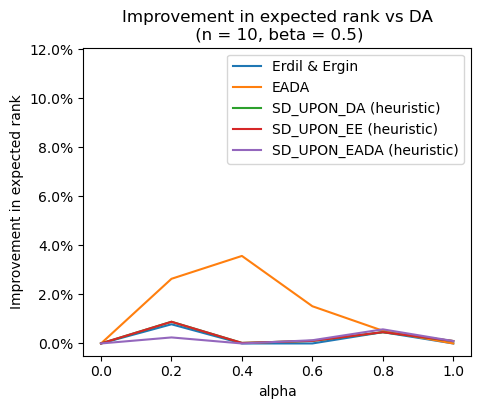

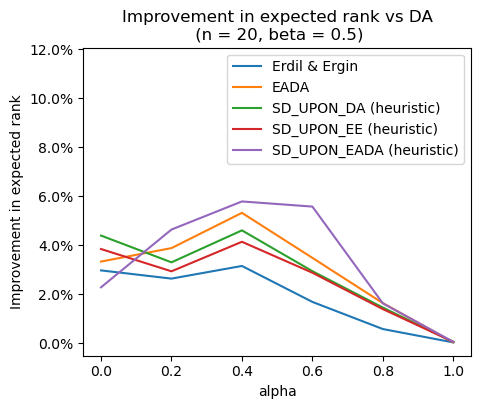

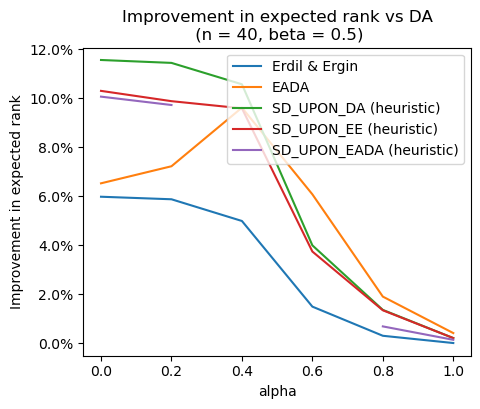

In [ ]:
SimulationsEvaluate("SIM_2025-07-29_131019", False)

## Estonian data

In [ ]:
file_path = "ReadData/Estonia/data_anon.txt" 
MyData = read_dataEstonia(file_path)
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

A_EADAM = EADAM_STB(MyData, n_iter, 0, True)

print(A.assignment)
A.statistics()
A_SIC.statistics()
A_EADAM.statistics()

In [ ]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
#MyModel = ModelColumnGen(MyData, A_SIC, A_SIC.assignment, True) # Compare to A_SIC

timeLimit = 3600
S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= timeLimit, n_sol_pricing = 10, gap_pricing= 0.1, bool_ColumnGen=True, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print(resultEE)
print(result)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


In [ ]:
# Generate a second subset of matchings, and test column generation with that
# (10 June 2025: not yet configured for use of warm start)
n_iter = 1000
bool_SIC = True # Run SICs immediately?
B = DA_STB(MyData, n_iter, 'GS', bool_SIC, 1, True)
B_SIC = SIC_all_matchings(MyData, B, True)
A_SIC.M_set = copy.deepcopy(B_SIC.M_set)
MyModel2 = ModelColumnGen(MyData, A_SIC, A.assignment, True)
qq = MyModel2.Solve("TRAD", "GUROBI", print_log=True, print_out=False)


## Run initial IP on generated data
Specify the number of students and schools, and run the models for this data.

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 6, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
MyData = generate_data(n_students=1000, n_schools=50, parameters = parameters, name="Test_DataGen_EE_vs_GS", print_data=False, seed = 0)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 20
bool_SIC = True # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)
print(A.assignment)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
    # 'STABLE' refers to maximizing the fraction of STABLE matchings in the decomposition
MyModel = Model(MyData, A, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
# Asses and visualize the difference
name_diff = name + '_diff'
diff = Assignment(MyData, q.assignment - A.assignment, name_diff)
diff.visualize()

## Heuristic subset weakly stable matchings
Runs an LP that minimizes the average rank while stochastically dominating the DA assignment with single-tie breaking, and while only using matchings that were used to compute DA probabilities. This is a heuristic.

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
MyData = generate_data(n_students=10, n_schools=4, parameters = parameters, name="500_25", print_data=False, seed = 1)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = True # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)
print(A.assignment)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
MyModel = ModelHeuristicLP(MyData, A, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
print(np.max(q.assignment-A.assignment))

In [ ]:
# Asses and visualize the difference
diff = Assignment(MyData, q.assignment - A.assignment, "40_12_Diff")
diff.visualize()

## Heuristic Fractional stable random matching

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
MyModelFS = ModelFracStable(MyData, A, True)
q = MyModelFS.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# FInd decomposition over weakly stable matchings of this fractionally stable matching (if decomposition exists)
MyModelCHECK = Model(MyData, q, True)
q_check = MyModelCHECK.Solve("STABLE", "GUROBI", True)

## Run code manual data
Manually enter data.

In [ ]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

In [ ]:
# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)


In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

A_EADAM = EADAM_STB(MyData, n_iter, 0, True)

print(A.assignment)
A.statistics()
A_SIC.statistics()
A_EADAM.statistics()

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
    # 'STABLE' refers to maximizing the fraction of STABLE matchings in the decomposition
MyModel = Model(MyData, A, False)
q = MyModel.Solve("IMPR_RANK", "GUROBI", False)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
# Asses and visualize the difference
diff = Assignment(MyData, q.assignment - p, "Ex_paper_Diff")
diff.visualize()

In [ ]:
tuple([1,2])

# Erdil & Ergin experiments

In [ ]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)


In [ ]:
# Do tie-breaking
permut = generate_permutations_STB(MyData, 1, seed = 3)

prior_new = generate_strict_prior_from_perturbation(MyData, permut[0])

Data_new_prior = Data(MyData.n_stud, MyData.n_schools, MyData.pref, prior_new, MyData.cap, MyData.ID_stud, MyData.ID_school, MyData.file_name)

# DA code Erdil & Ergin
N = transform_pref_us_to_EE(Data_new_prior)
A = transform_prior_us_to_EE(Data_new_prior)
Q = MyData.cap
result = DA_Erdil_ergin(N,A,Q)
print(result)
print(type(result['proposeoffset']))

M = gale_shapley(Data_new_prior)
print(type(M))
print(M)

M = np.zeros((4,4))
M[0,1] = 1
M[1,2] = 1
M[2,3] = 1
M[3,0] = 1
print(M)
print(M[0,1] == 1)

M_out = SIC(MyData, M, False)
print(M_out)

In [ ]:
bool_SIC = False # Run SICs immediately?
AssignmentGS = DA_STB(MyData, 10, 'GS', bool_SIC, 0)
ASIC = SIC_all_matchings(MyData, AssignmentGS, True)

print(AssignmentGS.assignment)




# EADAM tests

In [ ]:
# Example paper Tang & Yu (2014)
n_stud = 4
n_schools = 4

file_name = "Ex_paper_TangYu"

# Preferences students
pref = [[1, 0],
        [0, 2],
        [0, 1],
        [2, 3]]

# Priorities schools
prior = [[0, 1, 2],
         [2, 0],
         [1, 3],
        [3]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = [0, 1, 2, 3]
ID_school = [0, 1, 2, 3]

# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)
consent = [1, 1, 1, 1]


In [ ]:
# Example 3 paper Kesten 
n_stud = 6
n_schools = 5

file_name = "Ex3_paper_Kesten"

# Preferences students
pref = [[2, 1, 3],
        [3, 1, 5],
        [3, 4, 2],
        [1, 2, 4],
        [1, 5],
        [4,1,3,2,5]]

# Priorities schools
prior = [[2,1,5,6,4,3],
         [3,6,4,1,2,5],
         [1,6,2,3,4,5],
        [4,3,6,1,2,5],
        [1,2,3,4,5,6]]


# Capacities schools
cap = [1,1,1,1,2]

# Names of students and schools
ID_stud = [1, 2, 3, 4, 5, 6]
ID_school = [1, 2, 3, 4, 5]

# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)
consent = [1,1,1,1,1,1]


In [ ]:
M = EADAM(MyData, consent, False)
print(M)

# Quick tests


In [ ]:
n_stud = 2000
n_schools = 30
pref_list_length = n_schools
alpha_in = 0.2
beta_in = 0
seed = 1
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)


In [ ]:
ALPHA_INCREMENT = 0.2
BETA_INCREMENT = 0.4

alpha_list = list(np.arange(0, 1.0, ALPHA_INCREMENT)) 
beta_list = list(np.arange(0, 1.0, BETA_INCREMENT))

print(alpha_list)
print(type(alpha_list))


In [ ]:
M = np.zeros((5,3))
M[0,1] = 1
M[0,2] = 1
print(sum(M[0]))
print(sum(M[1]))

In [ ]:
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

pref[1].remove('4')
print(pref)

In [6]:
T = range(5)
print(len(T))

5


In [88]:
np.empty(shape=(3, 4))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [7]:
test = LpProblem('Test', LpMaximize)
X1 = LpVariable('X1', 0, 10)
X2 = LpVariable('X2', 0, 10)
test+= X1 + X2 <= 5
test += X1 + X2 +1000000
test.writeLP('Test.lp')
solver_function = globals()['GUROBI']
test.solve(solver_function())
print('\nOptimal objective value is', value(test.objective))



Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 2 columns and 2 nonzeros
Model fingerprint: 0x41c950ee
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [5e+00, 5e+00]
Presolve removed 1 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.000000000e+00
Gurobi status= 2

Optimal objective value is 1000005.0
